# Исследование тарифных планов

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше. 

## Описание тарифов

### Тариф «Смарт»

1) Ежемесячная плата: 550 рублей

2) Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

3) Стоимость услуг сверх тарифного пакета:

    минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.)
    сообщение: 3 рубля
    1 Гб интернет-трафика: 200 рублей
    
### Тариф «Ультра»

1) Ежемесячная плата: 1950 рублей

2) Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

3) Стоимость услуг сверх тарифного пакета:

    минута разговора: 1 рубль
    сообщение: 1 рубль
    1 Гб интернет-трафика: 150 рублей
    
    
**В ходе исследования будет необходимо проверить следующие гипотезы:**

1) средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;

2) средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

**Описание данных:**

1) Таблица users (информация о пользователях):

    user_id — уникальный идентификатор пользователя
    first_name — имя пользователя
    last_name — фамилия пользователя
    age — возраст пользователя (годы)
    reg_date — дата подключения тарифа (день, месяц, год)
    churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    city — город проживания пользователя
    tariff — название тарифного плана
    
2) Таблица calls (информация о звонках):

    id — уникальный номер звонка
    call_date — дата звонка
    duration — длительность звонка в минутах
    user_id — идентификатор пользователя, сделавшего звонок
    
3) Таблица messages (информация о сообщениях):

    id — уникальный номер сообщения
    message_date — дата сообщения
    user_id — идентификатор пользователя, отправившего сообщение
    
4) Таблица internet (информация об интернет-сессиях):

    id — уникальный номер сессии
    mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    session_date — дата интернет-сессии
    user_id — идентификатор пользователя

5) Таблица tariffs (информация о тарифах):

    tariff_name — название тарифа
    rub_monthly_fee — ежемесячная абонентская плата в рублях
    minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    messages_included — количество сообщений в месяц, включённых в абонентскую плату
    mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Шаг 1. Изучение общей информации. <a id='section1'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math
import plotly.figure_factory as ff
import seaborn as sns

In [2]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [4]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


В столбце с датой прекращения пользования тарифом churn_date присутствуют пропуски из-за того, что у пользователей с незаполненым полей тариф был активен на момент выгрузки данных. 2 столбца имеют целочисленный тип int64 и 6 строковый object.

In [5]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [6]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Пропусков не обнаружено, но в столбце с продолжительностью звонка duration присутствуют нулевые значения. 1 столбец имеет вещественный тип float64, 1 целочисленный тип int64 и 2 строковый object.

In [7]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [8]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Пропусков не обнаружено, но присутствует полностью заполненый безымянный столцец, который дублирует индексы таблицы. 1 столбец имеет вещественный тип float64, 2 целочисленный тип int64 и 2 строковый object.

In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [10]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Пропусков не обнаружено. 1 столбец имеет целочисленный тип int64 и 2 строковый object.

In [11]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [12]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Пропусков не обнаружено. 7 столбцов имеют целочисленный тип int64 и 1 строковый object.

### Вывод

Из полученных данных о 5 таблицах видно, что их необходимо обработать:

1) В ***users*** обработать пропуски в столбце churn_date и изменить тип данных в столбцах:

    user_id - int16
    age - int8
    churn_date - datetime64
    reg_date - datetime64
    
2) В ***calls*** изменить тип данных в столбцах:

    call_date - datetime64
    duration - float32
    user_id - int16

3) В ***internet*** изменить тип данных в столбцах:

    session_date - datetime64
    mb_used - float32
    user_id - int16

4) В ***messages*** изменить тип данных в столбцах:

    message_date - datetime64
    user_id - int16
    
5) В ***tariffs*** изменить тип данных в столбцах:

    messages_included - uint16
    mb_per_month_included - uint16
    minutes_included - uint16
    rub_monthly_fee - uint16
    rub_per_gb - uint8
    rub_per_message - uint8
    rub_per_minute - uint8

## Шаг 2. Предобработка данных <a id='section2'></a>

### Замена типа данных <a id='section4'></a>

Для начала изменим тип данных столбцов таблицы users.

In [13]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['churn_date']

0            NaT
1            NaT
2            NaT
3            NaT
4            NaT
         ...    
495          NaT
496          NaT
497          NaT
498   2018-10-25
499          NaT
Name: churn_date, Length: 500, dtype: datetime64[ns]

In [14]:
users['user_id'] = users['user_id'].astype('int16')
users['age'] = users['age'].astype('int8')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int16
age           500 non-null int8
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int16(1), int8(1), object(4)
memory usage: 25.0+ KB


Изменим тип данных столбцов таблицы calls.

In [15]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['user_id'] = calls['user_id'].astype('int16')
calls['duration'] = calls['duration'].astype('float32')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float32
user_id      202607 non-null int16
dtypes: datetime64[ns](1), float32(1), int16(1), object(1)
memory usage: 4.3+ MB


Изменим тип данных столбцов таблицы internet.

In [16]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['user_id'] = internet['user_id'].astype('int16')
internet['mb_used'] = internet['mb_used'].astype('float32')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float32
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int16
dtypes: datetime64[ns](1), float32(1), int16(1), int64(1), object(1)
memory usage: 4.3+ MB


Изменим тип данных столбцов таблицы messages.

In [17]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['user_id'] = messages['user_id'].astype('int16')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int16
dtypes: datetime64[ns](1), int16(1), object(1)
memory usage: 2.1+ MB


Изменим тип данных столбцов таблицы tariffs.

In [18]:
tariffs['messages_included'] = tariffs['messages_included'].astype('uint16')
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'].astype('uint16')
tariffs['minutes_included'] = tariffs['minutes_included'].astype('uint16')
tariffs['rub_monthly_fee'] = tariffs['rub_monthly_fee'].astype('uint16')
tariffs['rub_per_gb'] = tariffs['rub_per_gb'].astype('uint8')
tariffs['rub_per_message'] = tariffs['rub_per_message'].astype('uint8')
tariffs['rub_per_minute'] = tariffs['rub_per_minute'].astype('uint8')
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null uint16
mb_per_month_included    2 non-null uint16
minutes_included         2 non-null uint16
rub_monthly_fee          2 non-null uint16
rub_per_gb               2 non-null uint8
rub_per_message          2 non-null uint8
rub_per_minute           2 non-null uint8
tariff_name              2 non-null object
dtypes: object(1), uint16(4), uint8(3)
memory usage: 166.0+ bytes


### Вывод

В таблицах были изменены типы данных:

1) В ***users***:

    user_id - int16
    age - int8
    churn_date - datetime64
    reg_date - datetime64
    
2) В ***calls***:

    call_date - datetime64
    duration - float32
    user_id - int16

3) В ***internet***:

    session_date - datetime64
    mb_used - float32
    user_id - int16

4) В ***messages***:

    message_date - datetime64
    user_id - int16
    
5) В ***tariffs***:

    messages_included - uint16
    mb_per_month_included - uint16
    minutes_included - uint16
    rub_monthly_fee - uint16
    rub_per_gb - uint8
    rub_per_message - uint8
    rub_per_minute - uint8

### Обработка ошибок <a id='section3'></a>

In [19]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


В столбце duration таблицы calls присутствуют нулевые значения. Построим гистограмму.

Text(0.5, 1.0, 'Гистограмма продождительности звонков')

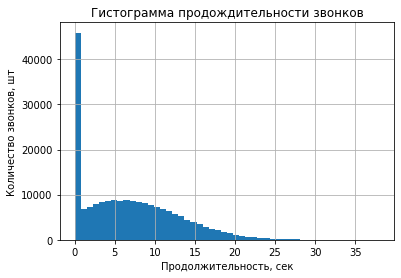

In [20]:
calls.hist('duration', bins=50)
plt.xlabel('Продолжительность, сек')
plt.ylabel('Количество звонков, шт')
plt.title('Гистограмма продождительности звонков')

На гистограмме есть 2 пика: первый в нуле, что говорит о присутствии звонков без продолжительности (возможно это попытка дозвониться или неудавшийся звонок), и второй в районе 6 секунд. Построим гистограмму по срезу, не включающему звонки с нулевой продолжительностью.

Text(0.5, 1.0, 'Гистограмма продождительности звонков')

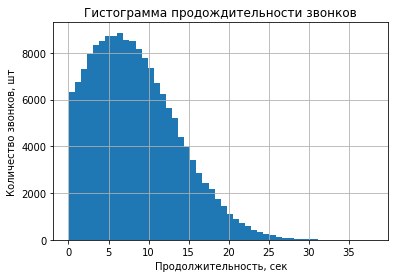

In [21]:
(calls
     .query('duration > 0')
     .hist('duration', bins=50)
)
plt.xlabel('Продолжительность, сек')
plt.ylabel('Количество звонков, шт')
plt.title('Гистограмма продождительности звонков')

Гистограмма среза напоминает распределение Пуассона, что говорит, о правдоподобности представленных данных.

Обработка таблицы internet.

In [22]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float32
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int16
dtypes: datetime64[ns](1), float32(1), int16(1), int64(1), object(1)
memory usage: 4.3+ MB


Удалим из таблицы безымянный столбец.

In [23]:
internet = internet[['id', 'mb_used', 'session_date', 'user_id']]
internet.describe()

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192444,1252.099842
std,278.300964,144.050823
min,0.000000,1000.000000
25%,138.187496,1130.000000
50%,348.014999,1251.000000
75%,559.552490,1380.000000
max,1724.829956,1499.000000


Построим гистограмму для столбца mb_used.

Text(0.5, 1.0, 'Гистограмма объема потраченного трафика')

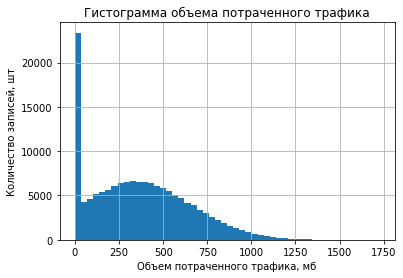

In [24]:
internet.hist('mb_used', bins=50)
plt.xlabel('Объем потраченного трафика, мб')
plt.ylabel('Количество записей, шт')
plt.title('Гистограмма объема потраченного трафика')

На гистограмме есть 2 пика: первый в нуле, что говорит о присутствии сессий, когда пользователь не выходил в интернет, и второй в районе 350 мб. Построим гистограмму по срезу, не включающему сессии с нулевым трафиком.

Text(0.5, 1.0, 'Гистограмма объема потраченного трафика')

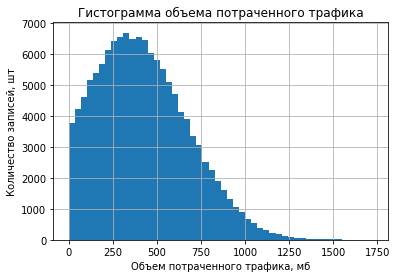

In [25]:
(internet
     .query('mb_used > 0')
     .hist('mb_used', bins=50)
)
plt.xlabel('Объем потраченного трафика, мб')
plt.ylabel('Количество записей, шт')
plt.title('Гистограмма объема потраченного трафика')

Гистограмма среза напоминает распределение Пуассона, что говорит, о правдоподобности представленных данных.

### Вывод

В таблицах calls и internet были обнаружены выбивающиеся значения, а именно нулевой объема трафика за сессию и нулевую продолжительность звонка. В дальнейшем по ним будут созданы срезы.

### Расчет для каждого пользователя количества звонков, сообщений, объема интернет-трафика и выручки. <a id='section5'></a>

Добавим в таблицу calls столбец с месяцами совершения звонков и возьмем срез данных без звонков с нулевой продолжительностью.

In [26]:
calls['month'] = calls['call_date'].dt.month

In [27]:
calls_correct = calls.query('duration > 0')

Создадим сводную таблицу с суммарной продолжительностью звонков для каждого пользователя по месяцам.

In [28]:
calls_month_sum = calls_correct.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum')
calls_month_sum

duration
user_id month            
1000    5      150.059998
        6      158.899994
        7      318.799988
        8      389.869995
        9      440.140015
...                   ...
1498    10     232.630005
1499    9       64.650002
        10     429.910004
        11     576.500000
        12     465.160004

[3168 rows x 1 columns]

Проделаем то же самое, но уже с количеством звонков.

In [29]:
calls_month_count = calls_correct.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
calls_month_count.columns = [['calls_count']]
calls_month_count

calls_count
user_id month            
1000    5              17
        6              28
        7              41
        8              42
        9              46
...                   ...
1498    10             30
1499    9               8
        10             44
        11             62
        12             56

[3168 rows x 1 columns]

Добавим в таблицу internet столбец с месяцами выхода в интернет и возьмем срез данных без сессий с нулевым трафиком.

In [30]:
internet['month'] = internet['session_date'].dt.month

In [31]:
internet_correct = internet.query('mb_used > 0')

Создадим сводную таблицу с суммарным трафиком для каждого пользователя по месяцам.

In [32]:
internet_month_sum = internet_correct.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_month_sum

mb_used
user_id month              
1000    5       2253.489990
        6      23233.769531
        7      14003.639648
        8      14055.929688
        9      14568.910156
...                     ...
1498    10     20579.359375
1499    9       1845.750000
        10     17788.509766
        11     17963.310547
        12     13055.580078

[3201 rows x 1 columns]

Добавим в таблицу messages столбец с месяцами отправки сообщений. Создадим сводную таблицу с суммарным количеством отправленных сообщений для каждого пользователя по месяцам.

In [33]:
messages['month'] = messages['message_date'].dt.month
messages_month_count = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_month_count.columns = [['messages_count']]
messages_month_count

messages_count
user_id month               
1000    5                 22
        6                 60
        7                 75
        8                 81
        9                 57
...                      ...
1498    10                42
1499    9                 11
        10                48
        11                59
        12                66

[2717 rows x 1 columns]

Создадим таблицу с тарифами для каждого пользователя.

In [34]:
tariff_dict = users.set_index('user_id')[['tariff']]
tariff_dict.head()

,tariff
user_id,
1000,ultra
1001,smart
1002,smart
1003,ultra
1004,ultra


Объединим все созданные таблицы и избавимся от мультииндексов.

In [35]:
data = calls_month_count.join([calls_month_sum, messages_month_count, internet_month_sum], how='outer')
data = data.join(tariff_dict)

for i in data.columns:
    data.rename({i:"".join(i)},axis=1,inplace=True)
data = data.reset_index()

data

,user_id,month,calls_count,duration,messages_count,mb_used,tariff
0,1000,5,17.0,150.059998,22.0,2253.489990,ultra
1,1000,6,28.0,158.899994,60.0,23233.769531,ultra
2,1000,7,41.0,318.799988,75.0,14003.639648,ultra
3,1000,8,42.0,389.869995,81.0,14055.929688,ultra
4,1000,9,46.0,440.140015,57.0,14568.910156,ultra
...,...,...,...,...,...,...,...
3209,1498,10,30.0,232.630005,42.0,20579.359375,smart
3210,1499,9,8.0,64.650002,11.0,1845.750000,smart
3211,1499,10,44.0,429.910004,48.0,17788.509766,smart
3212,1499,11,62.0,576.500000,59.0,17963.310547,smart


In [63]:
print(f'Количество клиентов: {data.user_id.nunique()}')

Количество клиентов: 498


В новой таблице с данными по каждому пользователю создадим столбец с выручкой, которую оператор связи получает каждый месяц с каждого пользователя. Для этого напишем функцию, в которой вычтем бесплатный лимит из суммарной продолжительности звонков, сообщений и интернет-трафика, получившиеся значения округлим в большую сторону, остаток умножим на значение из тарифного плана и прибавим абонентскую плату, соответствующую тарифному плану.

In [36]:
def profit(row):
    if row['tariff'] == 'smart':
        tariff = tariffs.loc[0]
    elif row['tariff'] == 'ultra':
        tariff = tariffs.loc[1]
    calls_plus = 0
    mb_plus = 0
    messages_plus = 0
    if row['duration'] > tariff['minutes_included']:
        calls_plus = math.ceil(row['duration'] - tariff['minutes_included']) * tariff['rub_per_minute']
    if row['mb_used'] > tariff['mb_per_month_included']:
        mb_plus = math.ceil((row['mb_used'] - tariff['mb_per_month_included']) / 1024) * tariff['rub_per_gb']
    if row['messages_count'] > tariff['messages_included']:
        messages_plus = (row['messages_count'] - tariff['messages_included']) * tariff['rub_per_message']
    return int(calls_plus + mb_plus + messages_plus + tariff['rub_monthly_fee'])

data['profit'] = data.apply(profit, axis=1)
data

,user_id,month,calls_count,duration,messages_count,mb_used,tariff,profit
0,1000,5,17.0,150.059998,22.0,2253.489990,ultra,1950
1,1000,6,28.0,158.899994,60.0,23233.769531,ultra,1950
2,1000,7,41.0,318.799988,75.0,14003.639648,ultra,1950
3,1000,8,42.0,389.869995,81.0,14055.929688,ultra,1950
4,1000,9,46.0,440.140015,57.0,14568.910156,ultra,1950
...,...,...,...,...,...,...,...,...
3209,1498,10,30.0,232.630005,42.0,20579.359375,smart,1750
3210,1499,9,8.0,64.650002,11.0,1845.750000,smart,550
3211,1499,10,44.0,429.910004,48.0,17788.509766,smart,1150
3212,1499,11,62.0,576.500000,59.0,17963.310547,smart,1408


### Вывод

Для каждого пользователя были подсчитаны следующие параметры:

    1) количество сделанных звонков и израсходованных минут разговора по месяцам;
    2) количество отправленных сообщений по месяцам;
    3) объем израсходованного интернет-трафика по месяцам;
    4) помесячная выручка с каждого пользователя

## Шаг 3. Анализ данных <a id='section6'></a>

Построим гистограмму числа пользователей каждого тарифа по месяцам.

Text(0.5, 1.0, 'Гистограмма числа пользователей по месяцам')

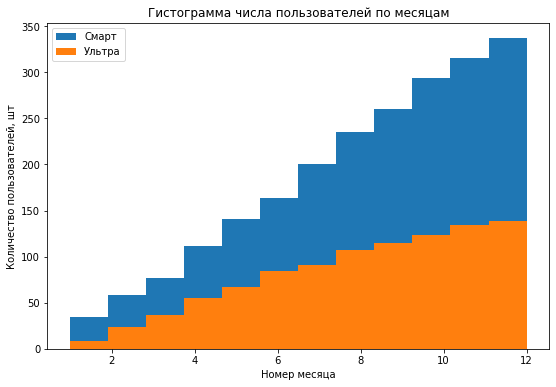

In [37]:
ax = (data
     .query('tariff == "smart"')
     .plot(kind='hist', y='month', bins=12, label='Смарт', figsize=(9,6))
)
(data
     .query('tariff == "ultra"')
     .plot(kind='hist', y='month', bins=12, ax=ax, label='Ультра')
)
plt.xlabel('Номер месяца')
plt.ylabel('Количество пользователей, шт')
plt.title('Гистограмма числа пользователей по месяцам')

Наблюдается рост пользователей обоих тарифов, это может быть связано с работой маркетинга по привлечению новых клиентов.

Построим графики для обоих тарифов, где каждому месяцу будут соответствовать средние значения продолжительности и числа звонков, числа сообщений и объема интернет трафика для всех пользователей.

Text(0.5, 1.0, 'График среднемесячной продолжительности звонков')

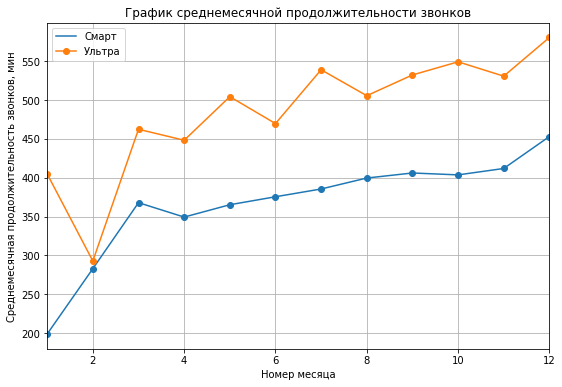

In [38]:
ax = (data
     .query('tariff == "smart"')
     .pivot_table(index='month', values='duration')
     .plot(y='duration', style='o-', grid=True, label='Смарт', figsize=(9,6))
)
(data
     .query('tariff == "ultra"')
     .pivot_table(index='month', values='duration')
     .plot(y='duration', style='o-', grid=True, ax=ax, label='Ультра')
)
plt.xlabel('Номер месяца')
plt.ylabel('Среднемесячная продолжительность звонков, мин')
plt.title('График среднемесячной продолжительности звонков')

Text(0.5, 1.0, 'График среднемесячной продолжительности звонков')

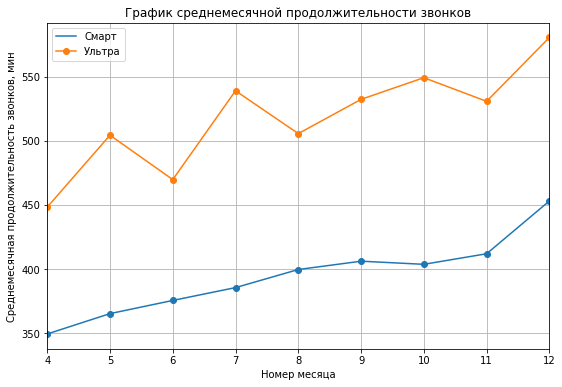

In [39]:
ax = (data
     .query('tariff == "smart" and month >= 4')
     .pivot_table(index='month', values='duration')
     .plot(y='duration', style='o-', grid=True, label='Смарт', figsize=(9,6))
)
(data
     .query('tariff == "ultra" and month >= 4')
     .pivot_table(index='month', values='duration')
     .plot(y='duration', style='o-', grid=True, ax=ax, label='Ультра')
)
plt.xlabel('Номер месяца')
plt.ylabel('Среднемесячная продолжительность звонков, мин')
plt.title('График среднемесячной продолжительности звонков')

Можно заметить, что среднемесячная продолжительность звонков растут у обоих тарифов причем примерно одинаковыми темпами. Так же заметно, что график тарифа "Ультра" куда более ступенчатый, чем у тарифа "Смарт". Это связано с тем, что тарифом "Ультра" изначально пользуются небольшое количество людей, что не добавляет графику определенности, но тем не менее, даже если не учитывать первые месяцы, пока у тарифов мало пользователей (первые 3 месяца), среднемесячная продолжительность звонков показывает устойчивый рост на протяжении всего года.

Text(0.5, 1.0, 'График среднемесячного количества звонков')

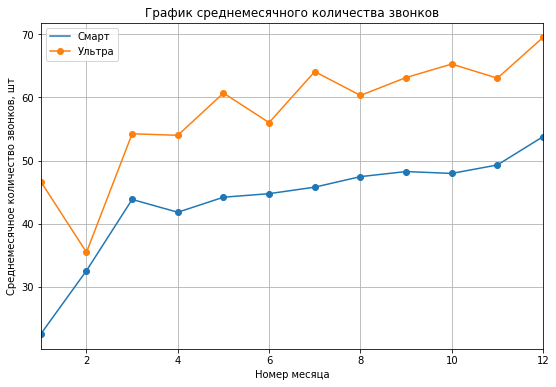

In [40]:
ax = (data
     .query('tariff == "smart"')
     .pivot_table(index='month', values='calls_count')
     .plot(y='calls_count', style='o-', grid=True, label='Смарт', figsize=(9,6))
)
(data
     .query('tariff == "ultra"')
     .pivot_table(index='month', values='calls_count')
     .plot(y='calls_count', style='o-', grid=True, ax=ax, label='Ультра')
)
plt.xlabel('Номер месяца')
plt.ylabel('Среднемесячное количество звонков, шт')
plt.title('График среднемесячного количества звонков')

График среднемесячного количества звонков полностью повторяет график среднемесячной продолжительности звонков. 

Text(0.5, 1.0, 'График среднемесячного количества сообщений')

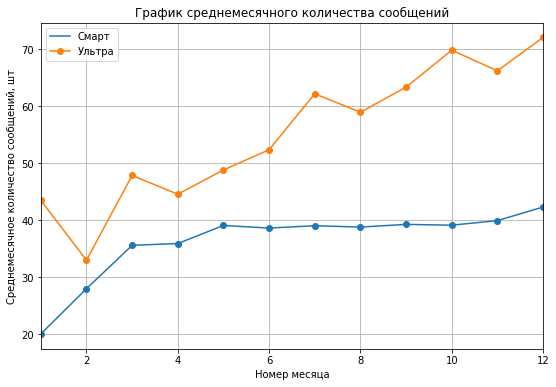

In [41]:
ax = (data
     .query('tariff == "smart"')
     .pivot_table(index='month', values='messages_count')
     .plot(y='messages_count', style='o-', grid=True, label='Смарт', figsize=(9,6))
)
(data
     .query('tariff == "ultra"')
     .pivot_table(index='month', values='messages_count')
     .plot(y='messages_count', style='o-', grid=True, ax=ax, label='Ультра')
)
plt.xlabel('Номер месяца')
plt.ylabel('Среднемесячное количество сообщений, шт')
plt.title('График среднемесячного количества сообщений')

По графику среднемесячного количества сообщений можно заметить, что рост отправки сообщений у тарифа "Смарт" заканчивается около 40 сообщений, когда позьзователи "Ультра" себя никак не ограничивают в количестве отправленных сообщений. Это может быть связано с тем, что пользователи тарифа "Смарт" искусственно ограничивают себя при приближении к лимиту отправленных сообщений по тарифу, который равен 50. Либо просто пользователи "Ультра" больше общаются посредством отправки сообщений, когда как использующие "Смарт" предпочитают какой-то другой вид связи или же просто не имеют необходимости отправлять больше сообщений в месяц.

Text(0.5, 1.0, 'График среднемесячного объема интернет трафика')

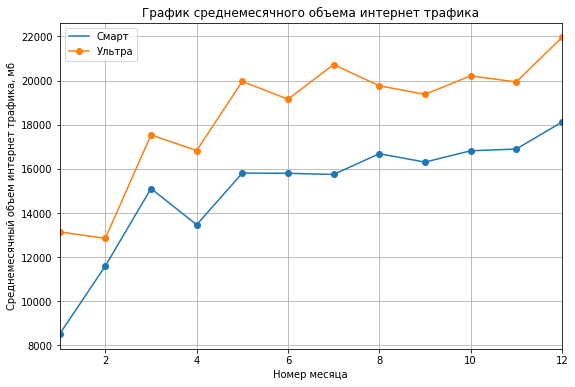

In [42]:
ax = (data
     .query('tariff == "smart"')
     .pivot_table(index='month', values='mb_used')
     .plot(y='mb_used', style='o-', grid=True, label='Смарт', figsize=(9,6))
)
(data
     .query('tariff == "ultra"')
     .pivot_table(index='month', values='mb_used')
     .plot(y='mb_used', style='o-', grid=True, ax=ax, label='Ультра')
)
plt.xlabel('Номер месяца')
plt.ylabel('Среднемесячный объем интернет трафика, мб')
plt.title('График среднемесячного объема интернет трафика')

По графику среднемесячного объема интернет трафика можно заметить, что рост объема трафика у обоих тарифов замедляется с 5 месяца. Причем пользователи тарифа "Смарт" с 5 месяца тратят в среднем больше трафика, чем предусмотрено тарифом (15 гб), тогда как пользователи тарифа "Ультра" замедляют увеличение потребление интернет трафика задолго до лимита, установленного тарифом (30 гб). Исходя из того, что характер графиков идентичен, можно утверждать, что рост останавливается из-за того, что пользователи обоих тарифов достигают оптимального потребления.

Так же судя по тому, что у тарифа "Смарт" нет изменения характера движения графиков ни на графике среднемесячного объема интернет трафика, ни на графике среднемесячной продолжительности звонков, можно утверждать, что пользователи этого тарифа не имеют нужды в отправке сообщений больше, чем было указано выше.

Text(0.5, 1.0, 'График среднемесячной выручки')

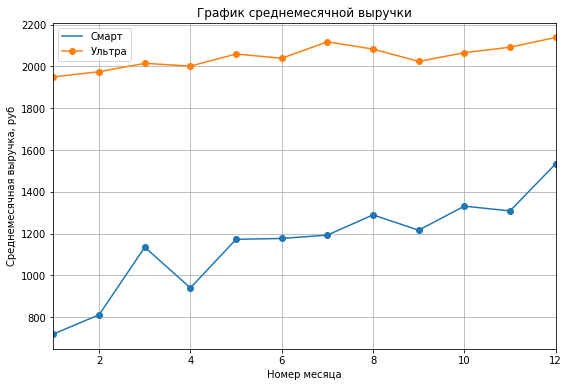

In [43]:
ax = (data
     .query('tariff == "smart"')
     .pivot_table(index='month', values='profit')
     .plot(y='profit', style='o-', grid=True, label='Смарт', figsize=(9,6))
)
(data
     .query('tariff == "ultra"')
     .pivot_table(index='month', values='profit')
     .plot(y='profit', style='o-', grid=True, ax=ax, label='Ультра')
)
plt.xlabel('Номер месяца')
plt.ylabel('Среднемесячная выручка, руб')
plt.title('График среднемесячной выручки')

По графику среднемесячной выручки можно судить о том, что пользователям тарифа "Смарт" не хватает заложенных в тарифном плане ограничений, что приводит к тому, что среднемесячная выручка у таких пользователей гораздо выше стоимости тарифа. Так же наблюдается ее рост на протяжении всего года, причем в куда более резкой форме, чем к пользователей тарифа "Ультра", которые куда больше довольны представленными ограничениями своего тарифного плана.

Создадим срез по каждому тирифу.

In [44]:
ultra = data.query('tariff == "ultra"')
smart = data.query('tariff == "smart"')

Создадим сводные таблицы со средними значениями, дисперсиями и стандартными отклонениями для каждого из параметров. 

***Средние значения:***

In [46]:
data.pivot_table(index='tariff', values=['calls_count', 'duration', 'messages_count', 'mb_used', 'profit'], aggfunc='mean')

,calls_count,duration,mb_used,messages_count,profit
tariff,,,,,
smart,47.116614,395.847748,16222.943359,38.716441,1257.588605
ultra,61.613516,517.013916,19688.679688,61.161006,2070.152284


Отсюда можно судить о том, что средние значения параметров тарифа "Ультра" везде больше, чем у тарифа "Смарт".

***Дисперсии:***

In [47]:
data.pivot_table(index='tariff', values=['calls_count', 'duration', 'messages_count', 'mb_used', 'profit'], aggfunc='var')

,calls_count,duration,mb_used,messages_count,profit
tariff,,,,,
smart,436.270629,31940.462891,34257208.0,717.594201,641465.797016
ultra,1168.901212,83232.296875,98567864.0,2109.659183,141516.745079


***Стандартные отклонения:***

In [48]:
data.pivot_table(index='tariff', values=['calls_count', 'duration', 'messages_count', 'mb_used', 'profit'], aggfunc='std')

,calls_count,duration,mb_used,messages_count,profit
tariff,,,,,
smart,20.887092,178.718949,5852.965744,26.787949,800.915599
ultra,34.189197,288.500081,9928.134971,45.931026,376.187114


Отсюда можно судить о том, что значения параметров тарифа "Ультра" имеют больший разброс, чем у тарифа "Смарт", везде кроме помесячной выручки. Это говорит о том, что пользователям "Ультра" реже приходится доплачивать за активное использование услуг из тарифа, чем "Смарт".

Построим гистограммы для каждого параметра и оценим распреления.

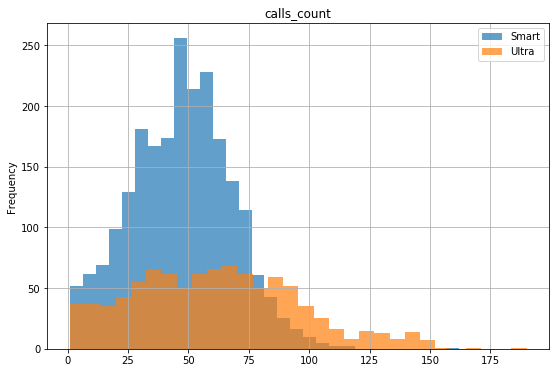

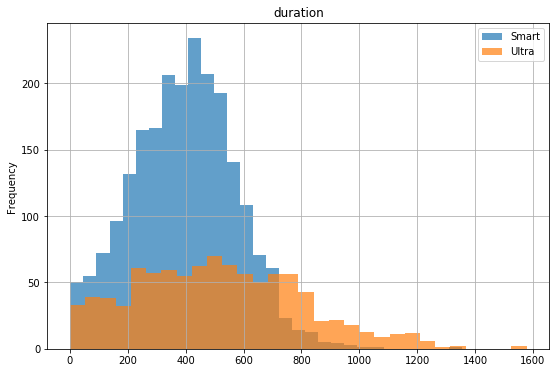

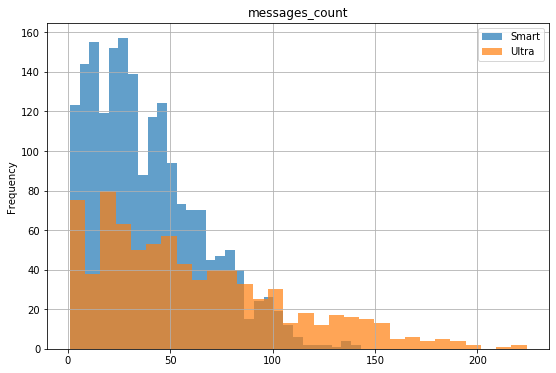

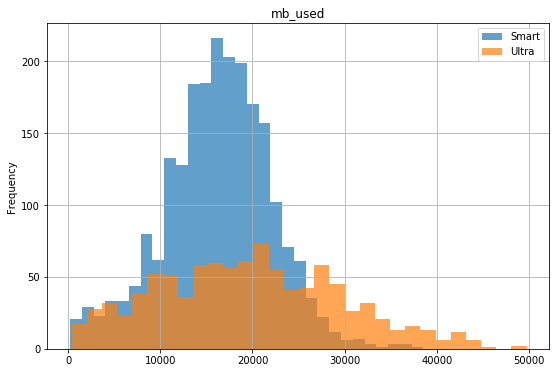

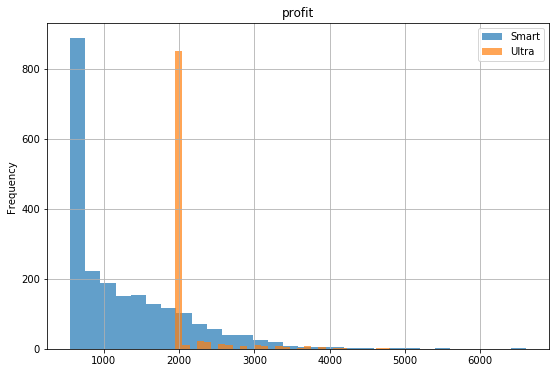

In [50]:
for i in ['calls_count', 'duration', 'messages_count', 'mb_used', 'profit']:
    ax = smart.plot(kind='hist', y=i, bins=30, alpha=0.7, figsize=(9, 6), label='Smart', title=i, grid=True)
    ultra.plot(kind='hist', y=i, bins=30, ax=ax, alpha=0.7, label='Ultra', grid=True)

Распределения количества и продолжительности звонков близки к нормальным (распределение Пуассона), тариф "Ультра" имеет куда более сглаженый пик, в отличие от "Смарт", это подтверждается сводной таблицей со стандартным отклонением (разброс "Ультра" больше чем "Смарт").

Распределение количества сообщений явно скошено вправо для обоих тарифов.

Распределение объема трафика - это распределение Пуассона без ярковыраженного скоса.

Гистограмма выручки для обоих тарифов имеет большой пик. Для тарифа "Ультра" значения вне пика не существенны и могут считаться выбросами.

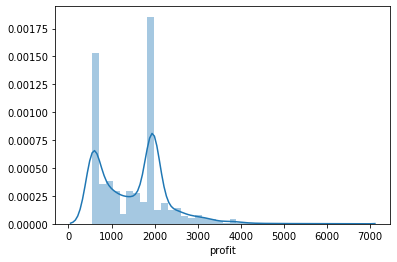

In [51]:
sns.distplot(data['profit'])

### Вывод

Наблюдается почти линейный рост пользователей обоих тарифов, это может быть связано с хорошей работой маркетинга, но в более дешевом тарифе "Смарт" пользователей значительно больше, чем в "Ультра".

В течении всего года наблюается рост среднемесячной продолжительности звонков, что, возможно, связано с тем, что средний пользователь перестает ощущать ограничения, заданные тарифным планом.

То же самое можно сказать и о среднемесячном объеме интернет трафика, потребляемом пользователями обоих тарифов, с тем лишь отличием, что рост этого показателя замедляется после набора большого числа пользователей, но не останавливается. Замедление может быть связано с достижением границы необходимого пользователю потребления, либо близостью к ней.

Если сравнивать тарифы по среднемесячному количеству отправленных сообщений, то пользователи тарифа "Ультра", у которых ограничение выше, отправляют каждый месяц все больше сообщений, а пользователи тарифа "Смарт" останавливают рост на отметке примерно в 40 сообщений. Это связано либо с тем, что пользователи тарифа "Смарт" ощущают близость ограничения по тарифу, что должно приводить к росту показателей объема интернет трафика и/или продолжительности звонков, либо с тем, что им требуется отправлять гораздо меньше сообщений, чем пользователям "Ультра".

По графику среднемесячной выручки можно судить о том, что пользователям тарифа "Смарт" не хватает заложенных в тарифном плане ограничений, что приводит к тому, что среднемесячная выручка у таких пользователей гораздо выше стоимости тарифа. Так же наблюдается ее рост на протяжении всего года, причем в куда более резкой форме, чем к пользователей тарифа "Ультра", которые чаще не выходят за представленные ограничения своего тарифного плана.

Пользователи тарифа "Ультра" в данной выборке в среднем в месяц совершают больше звонков и отправляют больше сообщений, имеют большую продолжительность звонков и тратят больше интернет трафика, чем пользователи "Смарт". Стандартные отклонения в "Ультра" тоже больше, за исключением выручки, что связано с тем, что пользователи реже выходят за ограничения и возможно переплачивают за полный тариф.

Гистограммы для всех параметров, кроме выручки, выглядят как распределения Пуассона, что говорит о корректности представленных данных. Выручка же имеет явно превышающий остальные значения пик, особенно у тарифа "Ультра".

<a href='#section0'> ***К оглавлению*** </a>

## Шаг 4. Проверка гипотез <a id='section7'></a>

Начнем с проверки тезиса "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается". Примем пороговое значение уровня статистической значимости за 5% и выделим выручку с пользователей, пользующихся разными тарифами, в разные совокупности.

In [54]:
alpha = 0.05

profit_ultra = ultra['profit']
profit_smart = smart['profit']

Сформируем нулевую и альтернативную гипотезы:

1) ***Нулевая гипотеза***: Средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковая.

2) ***Альтернативная гипотеза***: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Опровергнем или не опровергнем нулевую гипотезу, применив метод ttest_ind и проверим соответствие р-значения пороговому.

In [55]:
result = st.ttest_ind(profit_ultra, profit_smart)
print('p-значение:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем гипотезу')
else:
    print('Не получилось отвергнуть гипотезу')

p-значение: 1.513773301175091e-178
Отвергаем гипотезу


Так как нулевая гипотеза отвергнута, то делаем вывод, что средняя выручка пользователей тарифов «Ультра» и «Смарт» ***различается***.

Проверим тезис "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов". Пороговое значение уровня статистической значимости оставим равным 5%. Добавим к основной таблице город для каждого пользователя.

In [56]:
city_data = data.merge(users[['user_id','city']], on='user_id')
city_data

,user_id,month,calls_count,duration,messages_count,mb_used,tariff,profit,city
0,1000,5,17.0,150.059998,22.0,2253.489990,ultra,1950,Краснодар
1,1000,6,28.0,158.899994,60.0,23233.769531,ultra,1950,Краснодар
2,1000,7,41.0,318.799988,75.0,14003.639648,ultra,1950,Краснодар
3,1000,8,42.0,389.869995,81.0,14055.929688,ultra,1950,Краснодар
4,1000,9,46.0,440.140015,57.0,14568.910156,ultra,1950,Краснодар
...,...,...,...,...,...,...,...,...,...
3209,1498,10,30.0,232.630005,42.0,20579.359375,smart,1750,Владикавказ
3210,1499,9,8.0,64.650002,11.0,1845.750000,smart,550,Пермь
3211,1499,10,44.0,429.910004,48.0,17788.509766,smart,1150,Пермь
3212,1499,11,62.0,576.500000,59.0,17963.310547,smart,1408,Пермь


Заменим названия городов за значение "Другой", если город не является Москвой, для удобства восприятия информации.

In [57]:
def change_city(city):
    if city != 'Москва':
        return 'Другой'
    return city

city_data['city'] = city_data['city'].apply(change_city)
city_data

,user_id,month,calls_count,duration,messages_count,mb_used,tariff,profit,city
0,1000,5,17.0,150.059998,22.0,2253.489990,ultra,1950,Другой
1,1000,6,28.0,158.899994,60.0,23233.769531,ultra,1950,Другой
2,1000,7,41.0,318.799988,75.0,14003.639648,ultra,1950,Другой
3,1000,8,42.0,389.869995,81.0,14055.929688,ultra,1950,Другой
4,1000,9,46.0,440.140015,57.0,14568.910156,ultra,1950,Другой
...,...,...,...,...,...,...,...,...,...
3209,1498,10,30.0,232.630005,42.0,20579.359375,smart,1750,Другой
3210,1499,9,8.0,64.650002,11.0,1845.750000,smart,550,Другой
3211,1499,10,44.0,429.910004,48.0,17788.509766,smart,1150,Другой
3212,1499,11,62.0,576.500000,59.0,17963.310547,smart,1408,Другой


Создадим сводную таблицу, где каждому пользователю, будет соответствовать его город и его среднемесячная выручка.

In [59]:
city_grouped = city_data.pivot_table(index=['user_id', 'city'], values='profit').reset_index()
city_grouped

,user_id,city,profit
0,1000,Другой,1950.000000
1,1001,Москва,850.000000
2,1002,Другой,1035.714286
3,1003,Москва,1950.000000
4,1004,Другой,1950.000000
...,...,...,...
493,1495,Другой,2310.000000
494,1496,Другой,2308.333333
495,1497,Другой,899.333333
496,1498,Другой,1659.000000


Выделим выручки пользователей из москвы и из других городов в разные срезы.

In [60]:
moscow_data = city_grouped.query('city == "Москва"')['profit']
other_city_data = city_grouped.query('city == "Другой"')['profit']

Сформируем нулевую и альтернативную гипотезы:

1) ***Нулевая гипотеза***: Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.

2) ***Альтернативная гипотеза***: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Опровергнем или не опровергнем нулевую гипотезу, применив метод ttest_ind и проверим соответствие р-значения пороговому.

In [61]:
results = st.ttest_ind(
    moscow_data,
    other_city_data)
print('р-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем гипотезу')
else:
    print('Не получилось отвергнуть гипотезу')

р-значение: 0.37049058504190613
Не получилось отвергнуть гипотезу


Нулевую гипотезу не получилось отвергнуть, это значит, что ***нельзя наверняка утверждать***, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов, следовательно принимаем нулевую гипотезу.

### Вывод

Проверив гипотезы, мы опровергли гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковая, слеовательно была принята альтернативная гипотеза "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается".

Гипотезу о том, что средняя выручка пользователей из Москвы равна выручке пользователей из других регионов, опровергнуть не получилось, поэтому она была принята.

<a href='#section0'> ***К оглавлению*** </a>

## Шаг 5. Общий вывод <a id='section12'></a>

В проекте "Исследование тарифных планов" были проведены следующие мероприятия: определены пропуски, изменен тип данных некоторых столбцов, выполнен анализ данных для двух тарифов и были проверены 2 гипотезы. Было установлено, что тарифные планы "Ультра" и "Смарт" различаются, а значит можно выяснить какой из этих тарифов привлекательнее. Исходя из анализа данных по этим тарифам и проверенных гипотез можно утверждать, что тариф "Смарт" привлекает больше людей, так как он дешевле, а в случае превышения лимита прозволяет докупить нужные для пользователя услуги по приемлимой цене. Так же было установлено, что для пользователей "Смарт" возможно стоит скорректировать пороговое значение интернет трафика, так как оптимальное значение, судя по графикам, находится выше лимита, установленного сейчас.